In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats

# Load data
print("Loading data from .mat files...")


try:
    data_7p8 = scipy.io.loadmat('exercise_7p8_data.mat')
    print("exercise_7p8_data.mat keys:", list(data_7p8.keys()))
except FileNotFoundError:
    print("Files not found.")


Loading data from .mat files...
exercise_7p8_data.mat keys: ['__header__', '__version__', '__globals__', 'cement_data']


HEAT GENERATION IN CEMENT HARDENING - LINEAR REGRESSION ANALYSIS

Model: y = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + epsilon

REGRESSION RESULTS
Coefficient          Estimate     Std Error    t-stat     p-value   
----------------------------------------------------------------------
Intercept (b0)       62.4054      70.0710      0.8906     0.3991    
x1 (b1)              1.5511       0.7448       2.0827     0.0708    
x2 (b2)              0.5102       0.7238       0.7049     0.5009    
x3 (b3)              0.1019       0.7547       0.1350     0.8959    
x4 (b4)              -0.1441      0.7091       -0.2032    0.8441    

RESIDUAL ANALYSIS
Absolute, Average Error: 1.5871
Mean Squared Error (MSE): 3.6818

CONFIDENCE INTERVALS

Two Standard Deviation Intervals (~95.45%):
Coefficient          Lower Bound     Upper Bound    
----------------------------------------------------------------------
Intercept (b0)       -77.7365        202.5473       
x1 (b1)              0.0616          3.0406  

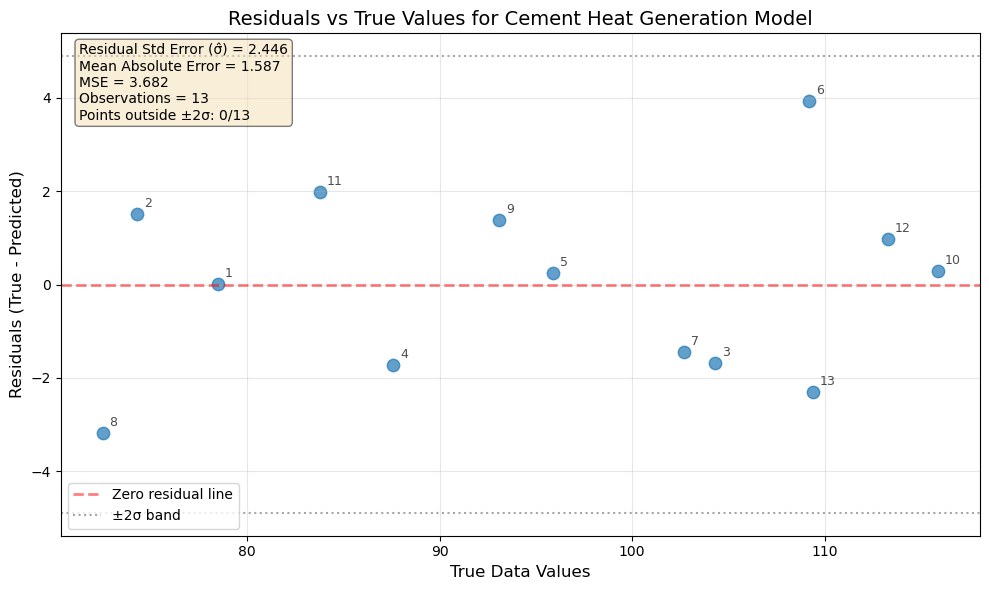

In [5]:
cement_data = data_7p8['cement_data']

# x1-x4 are the first 4 columns, y (heat) is the last column
X_data = cement_data[:, :4]  # x1, x2, x3, x4
y = cement_data[:, 4]        # heat (calories/gram cement)

n = len(y)

# (a) Fit linear model y = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + epsilon
# Add column of ones for intercept term
X = np.column_stack([np.ones(n), X_data])

XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
b = XtX_inv @ X.T @ y

y_pred = X @ b

# Calculate residuals
residuals = y - y_pred

# Calculate standard error and variance
AE = np.sum(np.abs(residuals))  # Absolute error
SSE = np.sum(residuals**2)  # Sum of squared errors
MSE = SSE / n  # Mean squared error
var = SSE / (n - X.shape[1])  # Mean squared error
sigma_hat = np.sqrt(var)  # Residual standard error

# Calculate standard errors for coefficients
var_b = var * XtX_inv
std_b = np.sqrt(np.diag(var_b))

# Calculate t-statistics and p-values for coefficients
t_stats = b / std_b
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n-X.shape[1]))

# Calculate confidence intervals
# Two standard deviation intervals
ci_two_sigma = np.column_stack([b - 2*std_b, b + 2*std_b])

# Print results
print("=" * 70)
print("HEAT GENERATION IN CEMENT HARDENING - LINEAR REGRESSION ANALYSIS")
print("=" * 70)
print("\nModel: y = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + epsilon")
print("\n" + "=" * 70)
print("REGRESSION RESULTS")
print("=" * 70)

coeff_names = ['Intercept (b0)', 'x1 (b1)', 'x2 (b2)', 'x3 (b3)', 'x4 (b4)']
print(f"{'Coefficient':<20} {'Estimate':<12} {'Std Error':<12} {'t-stat':<10} {'p-value':<10}")
print("-" * 70)
for i, name in enumerate(coeff_names):
    print(f"{name:<20} {b[i]:<12.4f} {std_b[i]:<12.4f} {t_stats[i]:<10.4f} {p_values[i]:<10.4f}")

print("\n" + "=" * 70)
print("RESIDUAL ANALYSIS")
print("=" * 70)
print(f"Absolute, Average Error: {AE/n:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")

print("\n" + "=" * 70)
print("CONFIDENCE INTERVALS")
print("=" * 70)
print("\nTwo Standard Deviation Intervals (~95.45%):")
print(f"{'Coefficient':<20} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)
for i, name in enumerate(coeff_names):
    print(f"{name:<20} {ci_two_sigma[i, 0]:<15.4f} {ci_two_sigma[i, 1]:<15.4f}")

print("\n2. 95% CONFIDENCE INTERVAL - NORMAL DISTRIBUTION (z-scores)")
print("   Coverage: Exactly 95% assuming normal distribution")
print("   Multiplier: 1.96")
z_critical = stats.norm.ppf(0.975)  # 1.96
ci_z_normal = np.column_stack([b - z_critical*std_b, b + z_critical*std_b])

print(f"{'Coefficient':<20} {'Lower Bound':<15} {'Upper Bound':<15} {'Width':<10}")
print("-" * 70)
for i, name in enumerate(coeff_names):
    width = ci_z_normal[i, 1] - ci_z_normal[i, 0]
    print(f"{name:<20} {ci_z_normal[i, 0]:<15.4f} {ci_z_normal[i, 1]:<15.4f} {width:<10.4f}")

# Create a single plot of residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y, residuals, alpha=0.7, s=80)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Zero residual line')
plt.axhline(y=2*sigma_hat, color='gray', linestyle=':', alpha=0.7, linewidth=1.5, label='±2σ band')
plt.axhline(y=-2*sigma_hat, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)

# Annotate each point with observation number
for i in range(n):
    plt.annotate(f'{i+1}', (y[i], residuals[i]), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=9, alpha=0.7)

plt.xlabel('True Data Values', fontsize=12)
plt.ylabel('Residuals (True - Predicted)', fontsize=12)
plt.title('Residuals vs True Values for Cement Heat Generation Model', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add text box with summary statistics
textstr = '\n'.join((
    f'Residual Std Error (σ̂) = {sigma_hat:.3f}',
    f'Mean Absolute Error = {AE/n:.3f}',
    f'MSE = {MSE:.3f}',
    f'Observations = {n}',
    f'Points outside ±2σ: {np.sum(np.abs(residuals) > 2*sigma_hat)}/{n}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()



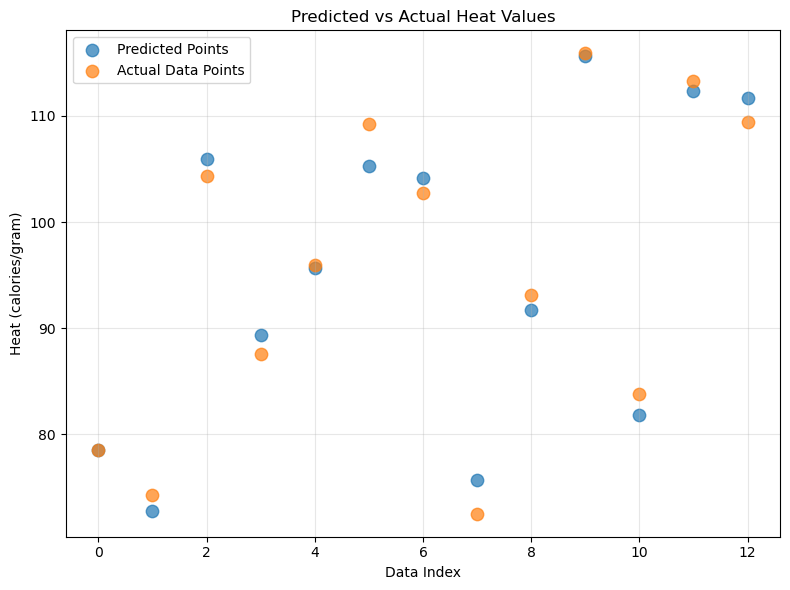

In [3]:
# Create a separate figure for predicted vs actual overall
fig2, ax = plt.subplots(figsize=(8, 6))

ax.scatter(range(len(y_pred)), y_pred, alpha=0.7, s=80, label='Predicted Points')
ax.scatter(range(len(y)), y, alpha=0.7, s=80, label='Actual Data Points')

ax.set_xlabel('Data Index')
ax.set_ylabel('Heat (calories/gram)')
ax.set_title('Predicted vs Actual Heat Values')

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




MODEL: x1 only
Estimated parameters:
b0 = 81.4793
b1 = 1.8687

Average residual (mean(abs difference)): 8.4947e+00
MSE: 115.0624

Two standard deviation intervals:
b0: [71.6247, 91.3340]
b1: [0.8159, 2.9216]

95% confidence intervals:
b0: [71.8219, 91.1367]
b1: [0.8370, 2.9005]


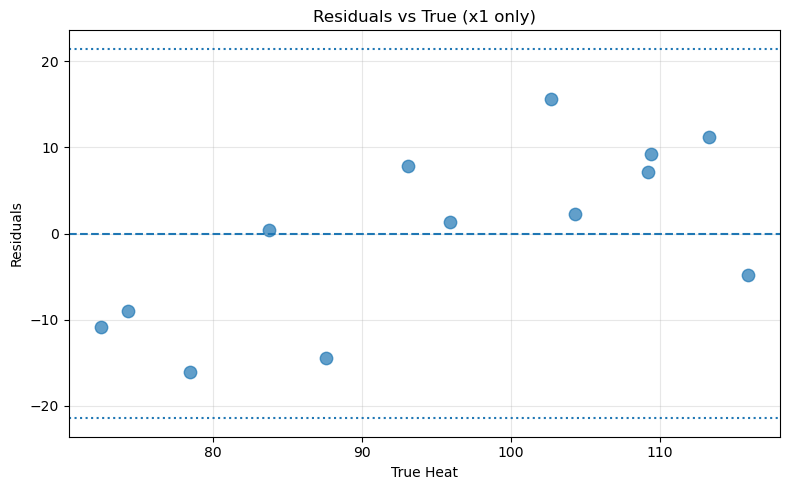

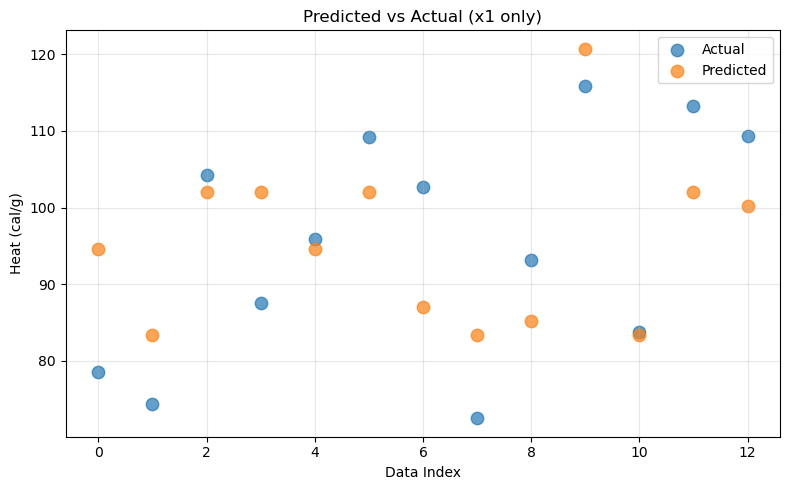


MODEL: x1 + x2
Estimated parameters:
b0 = 52.5773
b1 = 1.4683
b2 = 0.6623

Average residual (mean(abs difference)): 1.9093e+00
MSE: 5.7904

Two standard deviation intervals:
b0: [48.0050, 57.1497]
b1: [1.2257, 1.7109]
b2: [0.5705, 0.7540]

95% confidence intervals:
b0: [48.0965, 57.0582]
b1: [1.2306, 1.7061]
b2: [0.5724, 0.7521]


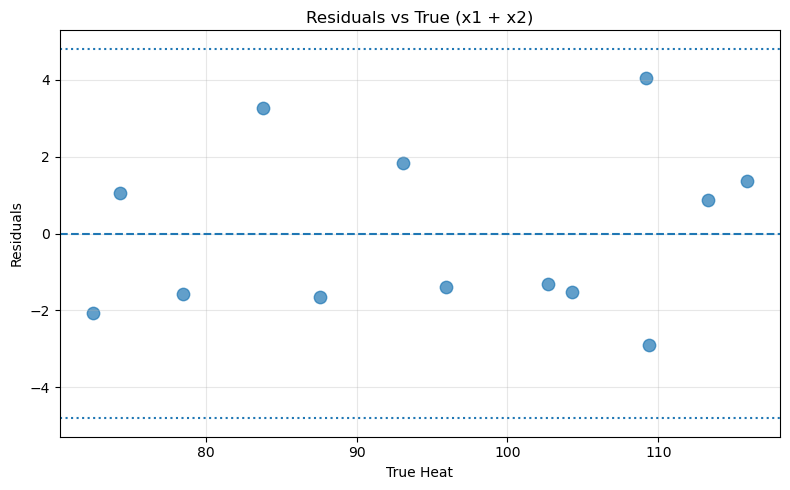

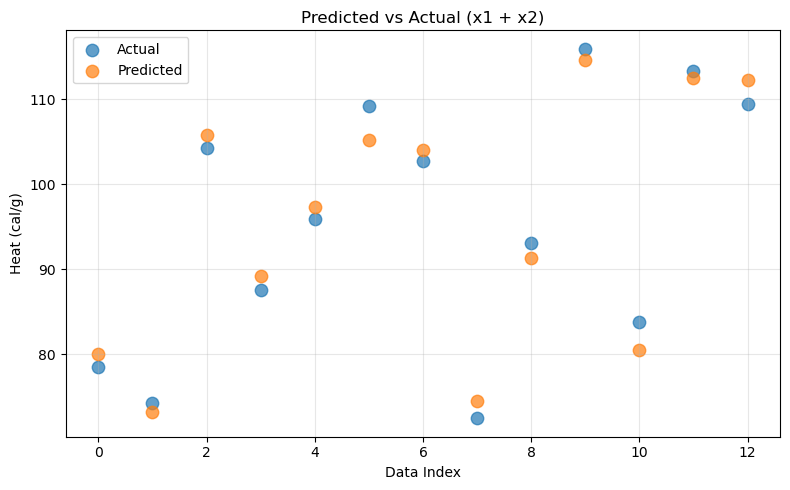


MODEL: x1 + x2 + x3 + x4
Estimated parameters:
b0 = 62.4054
b1 = 1.5511
b2 = 0.5102
b3 = 0.1019
b4 = -0.1441

Average residual (mean(abs difference)): 1.5871e+00
MSE: 5.9830

Two standard deviation intervals:
b0: [-77.7365, 202.5473]
b1: [0.0616, 3.0406]
b2: [-0.9374, 1.9577]
b3: [-1.4075, 1.6113]
b4: [-1.5622, 1.2740]

95% confidence intervals:
b0: [-74.9312, 199.7419]
b1: [0.0914, 3.0108]
b2: [-0.9084, 1.9288]
b3: [-1.3773, 1.5811]
b4: [-1.5338, 1.2457]


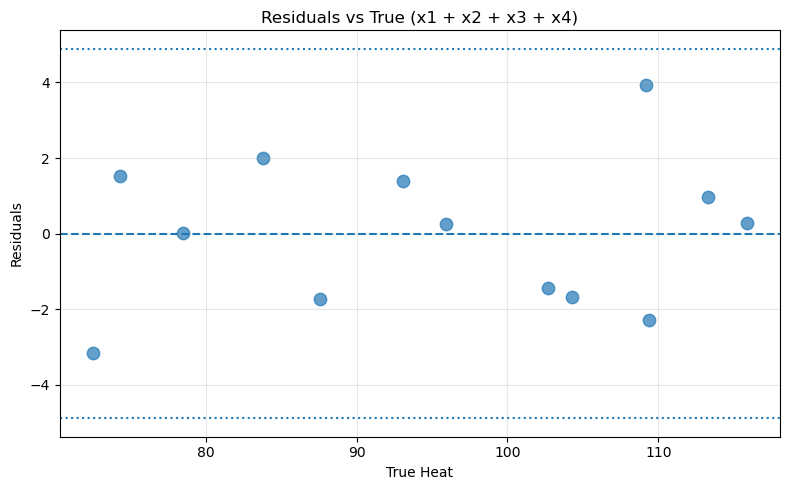

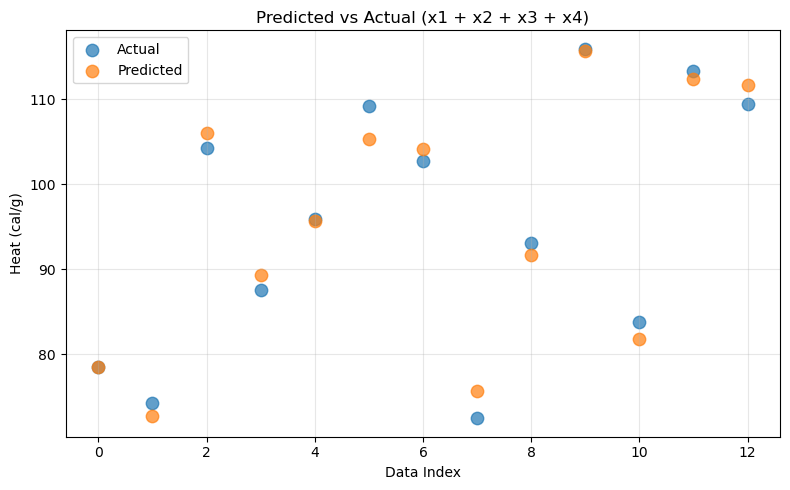

In [4]:
def fit_and_plot(X, y, model_name):
    n = len(y)
    X = np.column_stack([np.ones(n), X])
    p = X.shape[1]

    # Fit
    XtX_inv = np.linalg.inv(X.T @ X)
    b = XtX_inv @ X.T @ y
    y_pred = X @ b
    residuals = y - y_pred

    # Errors
    SSE = np.sum(residuals**2)
    MSE = SSE / (n - p)
    sigma_hat = np.sqrt(MSE)
    avg_resid = np.mean(np.abs(residuals))

    # Variance + SE
    var_b = MSE * XtX_inv
    std_b = np.sqrt(np.diag(var_b))

    # Confidence intervals
    ci_2sigma = np.column_stack([b - 2*std_b, b + 2*std_b])
    z = stats.norm.ppf(0.975)
    ci_95 = np.column_stack([b - z*std_b, b + z*std_b])

    # ---- PRINT RESULTS ----
    print("\n" + "="*60)
    print(f"MODEL: {model_name}")
    print("="*60)
    print("Estimated parameters:")
    for i, bi in enumerate(b):
        print(f"b{i} = {bi:.4f}")

    print(f"\nAverage residual (mean(abs difference)): {avg_resid:.4e}")
    print(f"MSE: {MSE:.4f}")

    print("\nTwo standard deviation intervals:")
    for i in range(p):
        print(f"b{i}: [{ci_2sigma[i,0]:.4f}, {ci_2sigma[i,1]:.4f}]")

    print("\n95% confidence intervals:")
    for i in range(p):
        print(f"b{i}: [{ci_95[i,0]:.4f}, {ci_95[i,1]:.4f}]")

    # ---- PLOTS ----
    # Residuals vs True
    plt.figure(figsize=(8,5))
    plt.scatter(y, residuals, s=80, alpha=0.7)
    plt.axhline(0, linestyle='--')
    plt.axhline(2*sigma_hat, linestyle=':')
    plt.axhline(-2*sigma_hat, linestyle=':')
    plt.xlabel('True Heat')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs True ({model_name})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(8,5))
    plt.scatter(range(n), y, s=80, alpha=0.7, label='Actual')
    plt.scatter(range(n), y_pred, s=80, alpha=0.7, label='Predicted')
    plt.xlabel('Data Index')
    plt.ylabel('Heat (cal/g)')
    plt.title(f'Predicted vs Actual ({model_name})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return b, avg_resid, ci_2sigma, ci_95, MSE

MSE_x1   = fit_and_plot(X_data[:, [0]], y, "x1 only")
MSE_x12  = fit_and_plot(X_data[:, [0,1]], y, "x1 + x2")
MSE_full = fit_and_plot(X_data, y, "x1 + x2 + x3 + x4")


With more variables in the model, we have a higher-capacity multilinear model rather than a single variable linear model. With more complexity in the model, the model can achieve higher accuracy (smaller residuals) to match the data (if the coefficients fo the model are optimized accurately, e.g., with the least squares method for linear models). With four variables, we have, on average, a residual of magnitude 1.5871 but with only 1 variablem, on average, we have a residual of 8.4947. Theoretically, with infinite (independent) variables, we might be able to achieve 100% accuracy on the training data; we will have overfit to the the training data's noise. However, generalizability will be low for the model.

Note: b0 represents the constant of the linear model, b1 represents the coefficient of x1, b2 the coefficient of x3, and so on.